# Atividade 01

## Regressão Logística I

Neste exercício vamos trabalhar com a base "Heart Disease Data Set" disponível no site do [UCI](https://archive.ics.uci.edu/ml/datasets/heart+disease).

Temos 303 indivíduos e vamos utilizar 13 variáveis disponíveis para prever a presença de doença cardíaca na variável ```num```(a 14$^a$ variável).

A descrição das variáveis está recortada abaixo:
- age: idade do paciente em anos
- sex: sexo (1 = male; 0 = female)  
- cp: tipo de dor no peito
  - 1: angina típica
  - 2: angina atípica
  - 3: dor não-angina
  - 4: assintomático
- trestbps: pressão sanguínea em repouso (em mm Hg na admissão ao hospital
- chol: colesterol sérico em mg/dl
- restecg: resultados eletrocardiográficos em repouso
  - 0: normal
  - 1: tendo anormalidade da onda ST-T (Inversões de onda T e / ou ST com elevação ou depressão de > 0.05 mV)
  - 2: mostrando hipertrofia ventricular esquerda provável ou definitiva pelos critérios de Estes
- thalach: frequência cardíaca máxima alcançada
- exang: angina induzida por exercício(1 = sim; 0 = não)
- oldpeak = Depressão de ST induzida por exercício em relação ao repouso
- slope: Depressão de ST induzida por exercício em relação ao repouso
  - 1: inclinação ascendente
  - 2: estável
  - 3: inclinação descendente
- ca: número de vasos principais (0-3) coloridos por fluorosopia
- thal: 3 = normal; 6 = defeito corrigido; 7 = defeito reversível
- num: diagnóstico de doença cardíaga (status de doença angiográfica)

In [1]:
# Importando bibliotecas
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
from prettytable import PrettyTable
from sklearn.calibration import calibration_curve
import statsmodels.api as sm
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier

In [2]:
# Definindo a URL do conjunto de dados
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data'

# Carregando os dados com nomes de colunas específicos
colunas = ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg',
           'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'num']
df = pd.read_csv(url, names=colunas)

# Exibindo as primeiras linhas do DataFrame
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0


In [3]:
# Criando uma coluna 'flag_doente' com valores binários indicando se a pessoa está doente ou não
df['flag_doente'] = (df['num'] != 0).astype('int64')

# Exibindo o DataFrame atualizado
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num,flag_doente
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2,1
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0,0


1. Monte uma bivariada para a variável ```sex``` com as seguintes estatísticas:

- Número de *saudáveis*
- Número de *doentes*
- Total
- Quantidade média de doentes
- *Odds*
- *Odds ratio* (Use o total como referência)
- Logito (LOG(*Odds*))
- O LOG do *Odds ratio* (com o total como referência) é chamado de *Weight of Evidence* (WOE). Calcule-o.

In [4]:
# Convertendo a coluna 'flag_doente' para numérica e lidando com erros
df['flag_doente'] = pd.to_numeric(df['flag_doente'], errors='coerce')

# Contando os valores únicos na coluna 'flag_doente'
value_counts = df['flag_doente'].value_counts()

# Obtendo o número de doentes e saudáveis
doentes = value_counts.get(1)
saudaveis = value_counts.get(0)
total = len(df)

# Calculando métricas estatísticas (considerando o caso em que saudaveis não é zero)
if saudaveis != 0:
    media_doentes = doentes / total # type: ignore
    odds = doentes / saudaveis # type: ignore
    odds_ratio = odds / (1 - odds)
    logito, woe = np.log(odds), np.log(odds_ratio)
else:
    media_doentes, odds, odds_ratio, logito, woe = np.nan, np.nan, np.nan, np.nan, np.nan

# Criando uma tabela para exibir as estatísticas
table = PrettyTable()
table.field_names = ["Estatística", "Valor"]
table.add_row(["Número de saudáveis", saudaveis])
table.add_row(["Número de doentes", doentes])
table.add_row(["Total", total])
table.add_row(["Quantidade média de doentes", f"{media_doentes:.2%}"])
table.add_row(["Odds", f"{odds:.4f}"])
table.add_row(["Odds ratio", f"{odds_ratio:.4f}"])
table.add_row(["Logito", f"{logito:.4f}"])
table.add_row(["Weight of Evidence (WOE)", f"{woe:.4f}"])
print(table)

+-----------------------------+---------+
|         Estatística         |  Valor  |
+-----------------------------+---------+
|     Número de saudáveis     |   164   |
|      Número de doentes      |   139   |
|            Total            |   303   |
| Quantidade média de doentes |  45.87% |
|             Odds            |  0.8476 |
|          Odds ratio         |  5.5600 |
|            Logito           | -0.1654 |
|   Weight of Evidence (WOE)  |  1.7156 |
+-----------------------------+---------+


2. Monte uma bivariada para a variável ```age``` com as seguintes estatísticas:
- Categorize a variável em 5 grupos
- Calcule as mesmas quantidades calculadas no execício anterior
- Calcule também o valor médio da variável ```age```

In [5]:
# Criando uma coluna 'age_group' com base na faixa etária
df['age_group'] = pd.cut(df['age'], bins=[29, 40, 50, 60, 70, 80], labels=['30-39', '40-49', '50-59', '60-69', '70-79'])

# Realizando análise bivariada em relação à faixa etária e status de saúde
bivariada_age = df.groupby('age_group', observed=False)['flag_doente'].agg(['count', 'sum', 'mean', 'min', 'max', 'mean'])

# Criando uma tabela para exibir as estatísticas bivariadas por faixa etária
table = PrettyTable()
table.field_names = ["Faixa Etária", "Contagem", "Soma", "Média", "Mínimo", "Máximo"]

# Preenchendo a tabela com os resultados da análise
for index, row in bivariada_age.iterrows():
    table.add_row([index, *row[:-1]])

# Exibindo a tabela
print(table)

+--------------+----------+------+---------------------+--------+--------+
| Faixa Etária | Contagem | Soma |        Média        | Mínimo | Máximo |
+--------------+----------+------+---------------------+--------+--------+
|    30-39     |   17.0   | 6.0  | 0.35294117647058826 |  0.0   |  1.0   |
|    40-49     |   76.0   | 23.0 |  0.3026315789473684 |  0.0   |  1.0   |
|    50-59     |  130.0   | 66.0 |  0.5076923076923077 |  0.0   |  1.0   |
|    60-69     |   73.0   | 43.0 |  0.589041095890411  |  0.0   |  1.0   |
|    70-79     |   6.0    | 1.0  | 0.16666666666666666 |  0.0   |  1.0   |
+--------------+----------+------+---------------------+--------+--------+


3. Visualize a informação da bivariada construída acima através de um gráfico da sua escolha.

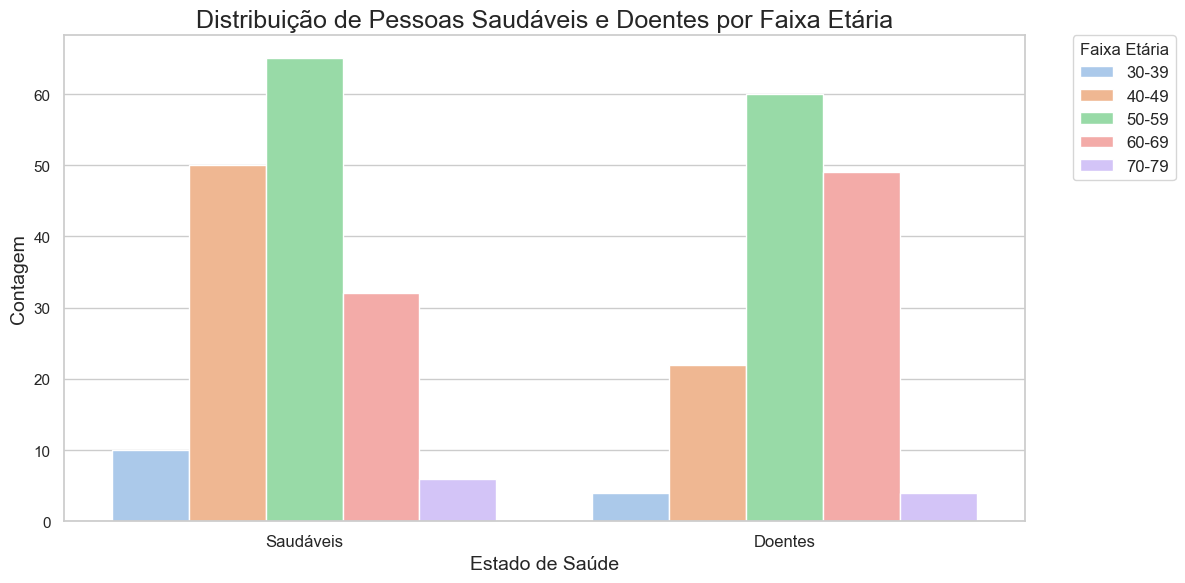

In [6]:
# Filtrando os valores NaN da coluna age_group
df = df.dropna(subset=['age_group'])
df = df[df['age_group'] != 'nan']

# Criando bins para idades
bins = range(0, 100, 10)
labels = [f'{i}-{i+9}' for i in range(0,90,10)]

# Criando uma nova coluna 'age_group' com idades agrupadas
df['age_group'] = pd.cut(df['age'], bins=bins, labels=labels, right=False)

# Configurando o estilo Seaborn
sns.set(style="whitegrid")

# Criando uma figura e eixos
plt.figure(figsize=(12, 6))

# Ordenando os grupos etários
age_group_order = sorted(df['age_group'].unique())

# Criando o countplot com separação por faixa etária
ax = sns.countplot(x='flag_doente', hue='age_group', data=df, palette='pastel', hue_order=age_group_order)

# Adicionando rótulos e título
ax.set_title('Distribuição de Pessoas Saudáveis e Doentes por Faixa Etária', fontsize=18)
ax.set_xlabel('Estado de Saúde', fontsize=14)
ax.set_ylabel('Contagem', fontsize=14)
ax.set_xticklabels(['Saudáveis', 'Doentes'], fontsize=12)

# Adicionando legenda
legend = ax.legend(title='Faixa Etária', bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., fontsize='12')

# Exibindo o gráfico
plt.tight_layout()
plt.show()

# Atividade 02

## Regressão Logística II

Vamos trabalhar com a mesma base do exercício anterior, mas vamos aprofundar um pouco mais a nossa regressão.

In [7]:
# Carregando dados do URL fornecido e renomeando as colunas
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data'
df = pd.read_csv(url, names=['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg',
                             'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'num'])

# Criando uma nova coluna 'flag_doente' indicando se a pessoa está doente (num diferente de zero)
df['flag_doente'] = (df['num'] != 0).astype('int64')

# Exibindo as primeiras linhas do DataFrame
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num,flag_doente
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2,1
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0,0


A descrição das variáveis está recortada abaixo:
- age: idade do paciente em anos
- sex: sexo (1 = male; 0 = female)  
- cp: tipo de dor no peito
  - 1: angina típica
  - 2: angina atípica
  - 3: dor não-angina
  - 4: assintomático
- trestbps: pressão sanguínea em repouso (em mm Hg na admissão ao hospital
- chol: colesterol sérico em mg/dl
- fbs: (açúcar no sangue em jejum > 120 mg/dl) (1 = True; 0 = False)
- restecg: resultados eletrocardiográficos em repouso
  - 0: normal
  - 1: tendo anormalidade da onda ST-T (Inversões de onda T e / ou ST com elevação ou depressão de > 0.05 mV)
  - 2: mostrando hipertrofia ventricular esquerda provável ou definitiva pelos critérios de Estes
- thalach: frequência cardíaca máxima alcançada
- exang: angina induzida por exercício(1 = sim; 0 = não)
- oldpeak = Depressão de ST induzida por exercício em relação ao repouso
- slope: Depressão de ST induzida por exercício em relação ao repouso
  - 1: inclinação ascendente
  - 2: estável
  - 3: inclinação descendente
- ca: número de vasos principais (0-3) coloridos por fluorosopia
- thal: 3 = normal; 6 = defeito corrigido; 7 = defeito reversível
- num: diagnóstico de doença cardíaga (status de doença angiográfica)

1. Considere o script que monta a análise bivariada que você fez na tarefa anterior. Transforme esse script em uma função, que deve:
- Ter como parâmetros de entrada:
    - Um *dataframe* contendo os dados a serem avaliados
    - Um *string* contendo o nome da variável resposta
    - Um *string* contendo o nome da variável explicativa
- E deve retornar um *dataframe* com os dados da bivariada. 
**Monte** a mesma bivariada pelo menos três variáveis qualitativas do *data-frame*. Qual delas parece discriminar mais o risco?

In [8]:
def bivariate_analysis(df, response_var, explanatory_var):
    # Criando uma coluna indicando se a pessoa está doente (response_var diferente de zero)
    df['flag_doente'] = (df[response_var] != 0).astype('int64')
    
    # Obtendo contagem de valores
    value_counts = df['flag_doente'].value_counts()
    doentes = value_counts.get(1)
    saudaveis = value_counts.get(0)
    total = len(df)

    if saudaveis != 0:
        # Calculando métricas
        media_doentes = doentes / total
        odds = doentes / saudaveis
        odds_ratio = odds / (1 - odds)
        logito, woe = np.log(odds), np.log(odds_ratio)
    else:
        # Se não houver pessoas saudáveis, atribuir NaN às métricas
        media_doentes, odds, odds_ratio, logito, woe = np.nan, np.nan, np.nan, np.nan, np.nan

    # Criando tabela PrettyTable para exibir resultados
    table = PrettyTable()
    table.field_names = ["Estatística", "Valor"]
    table.add_row(["Número de saudáveis", saudaveis])
    table.add_row(["Número de doentes", doentes])
    table.add_row(["Total", total])
    table.add_row(["Quantidade média de doentes", f"{media_doentes:.2%}"])
    table.add_row(["Odds", f"{odds:.4f}"])
    table.add_row(["Odds ratio", f"{odds_ratio:.4f}"])
    table.add_row(["Logito", f"{logito:.4f}"])
    table.add_row(["Weight of Evidence (WOE)", f"{woe:.4f}"])
    print(table)

# Exemplo de uso da função
bivariate_analysis(df, 'num', 'sex')

+-----------------------------+---------+
|         Estatística         |  Valor  |
+-----------------------------+---------+
|     Número de saudáveis     |   164   |
|      Número de doentes      |   139   |
|            Total            |   303   |
| Quantidade média de doentes |  45.87% |
|             Odds            |  0.8476 |
|          Odds ratio         |  5.5600 |
|            Logito           | -0.1654 |
|   Weight of Evidence (WOE)  |  1.7156 |
+-----------------------------+---------+


2. Monte uma função semelhante para categorizar variáveis quantitativas contínuas (com muitas categorias) como ```age```.  
    Além dos mesmos parâmetros da função anterior, defina mais um parâmetro como número de categorias que você deseja quebrar. Defina um valor '*default*' de 5 grupos para este parâmetro.  

In [9]:
def categorize_continuous_variable(df, variable, num_categories=5):
    # Criando uma nova coluna com categorias baseadas nos bins definidos
    df[f'{variable}_group'] = pd.cut(df[variable], bins=num_categories)
    
    # Agregando estatísticas para análise bivariada
    bivariate_var = df.groupby(f'{variable}_group', observed=False)['flag_doente'].agg(['count', 'sum', 'mean', 'min', 'max'])
    
    # Criando tabela PrettyTable para exibir resultados
    table = PrettyTable()
    table.field_names = ["Categoria", "Contagem", "Soma", "Média", "Mínimo", "Máximo"]

    for index, row in bivariate_var.iterrows():
        table.add_row([index, *row])
    print(table)

# Exemplo de uso da função
categorize_continuous_variable(df, 'age', num_categories=5)

+----------------+----------+------+---------------------+--------+--------+
|   Categoria    | Contagem | Soma |        Média        | Mínimo | Máximo |
+----------------+----------+------+---------------------+--------+--------+
| (28.952, 38.6] |   11.0   | 3.0  |  0.2727272727272727 |  0.0   |  1.0   |
|  (38.6, 48.2]  |   71.0   | 21.0 | 0.29577464788732394 |  0.0   |  1.0   |
|  (48.2, 57.8]  |   97.0   | 41.0 |  0.422680412371134  |  0.0   |  1.0   |
|  (57.8, 67.4]  |  107.0   | 67.0 |  0.6261682242990654 |  0.0   |  1.0   |
|  (67.4, 77.0]  |   17.0   | 7.0  |  0.4117647058823529 |  0.0   |  1.0   |
+----------------+----------+------+---------------------+--------+--------+


3. Construa um modelo de regressão logística com as variáveis qualitativas: ```sex + cp +  trestbps``` e com a variável quantitativa ```age```.

**Interprete os parâmetros.**

In [10]:
def fit_logistic_regression(df, predictors, response):
    # Ajustando a regressão logística e exibindo o resumo
    result_logistic = sm.Logit(df[response], sm.add_constant(df[predictors])).fit()
    print(result_logistic.summary())
    return result_logistic

# Especificando as variáveis preditoras e a variável de resposta
predictors = ['sex', 'cp', 'trestbps', 'age']
response_variable = 'flag_doente'

# Aplicando a função para ajustar a regressão logística
result_logistic = fit_logistic_regression(df, predictors, response_variable)

# Adicionando coluna de probabilidade predita ao DataFrame
df['predicted_prob'] = result_logistic.predict(sm.add_constant(df[predictors]))

# Tratando valores infinitos como NaN
df.replace([np.inf, -np.inf], np.nan, inplace=True)

# Convertendo as probabilidades para arrays NumPy
prob_true_np = np.asarray(df[response_variable])
prob_pred_np = np.asarray(df['predicted_prob'])

# Garantindo que as probabilidades estejam no intervalo [0, 1]
prob_pred_np = np.clip(prob_pred_np, 0, 1)

# Calculando a curva de calibração
prob_true, prob_pred = calibration_curve(prob_true_np, prob_pred_np, n_bins=10)

Optimization terminated successfully.
         Current function value: 0.510076
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:            flag_doente   No. Observations:                  303
Model:                          Logit   Df Residuals:                      298
Method:                           MLE   Df Model:                            4
Date:                Fri, 09 Feb 2024   Pseudo R-squ.:                  0.2605
Time:                        02:55:46   Log-Likelihood:                -154.55
converged:                       True   LL-Null:                       -208.99
Covariance Type:            nonrobust   LLR p-value:                 1.264e-22
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        -11.1167      1.608     -6.915      0.000     -14.267      -7.966
sex            1.8021      0.

4. Avalie o seu modelo quanto a **calibragem**:
- Calcule a probabilidade de evento predita segundo o seu modelo
- Categorize essa probabilidade em G=5 grupos
- Calcule a probabilidade de evento predita média por grupo
- Calcule a taxa de eventos (média da variável indicadora de eventos) por grupo
- Compare graficamente o valor eperado versus observado para a taxa de maus por grupo

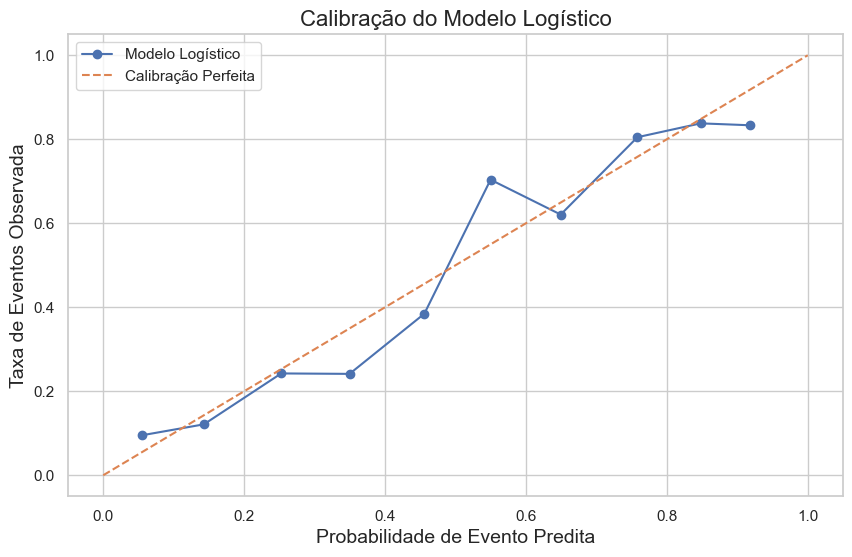

In [11]:
# Convertendo os argumentos para arrays NumPy
perfect_calibration_line_x = np.array([0, 1])
perfect_calibration_line_y = np.array([0, 1])

# Plotando a curva de calibração
plt.figure(figsize=(10, 6))
plt.plot(prob_pred, prob_true, marker='o', label='Modelo Logístico')
plt.plot(perfect_calibration_line_x, perfect_calibration_line_y, linestyle='--', label='Calibração Perfeita')
plt.ylabel('Taxa de Eventos Observada', fontsize=14)
plt.xlabel('Probabilidade de Evento Predita', fontsize=14)
plt.title('Calibração do Modelo Logístico', fontsize=16)
plt.legend()
plt.show()

5. Avalie o seu modelo quanto a discriminação calculando acurácia, GINI e KS.

In [12]:
# Predizendo as classes com base na probabilidade predita usando um limiar de 0.5
X_pred = sm.add_constant(df[predictors])

# Get the relevant columns from X_pred
X_pred = X_pred[result_logistic.params.index]

y_pred = (result_logistic.predict(X_pred) > 0.5).astype(int)

# Calculando métricas de desempenho
accuracy = accuracy_score(df[response_variable], y_pred)
roc_auc = roc_auc_score(df[response_variable], result_logistic.predict(X_pred))
gini = 2 * float(roc_auc) - 1
fpr, tpr, thresholds = roc_curve(df[response_variable], result_logistic.predict(X_pred))
ks = max(tpr - fpr)

# Exibindo as métricas
print(f"Acurácia: {accuracy:.4f}, AUC: {roc_auc:.4f}, GINI: {gini:.4f}, KS: {ks:.4f}")

Acurácia: 0.7789, AUC: 0.8311, GINI: 0.6622, KS: 0.5840


6. tente melhorar o modelo obtido, por exemplo inserindo ou removendo variáveis.  
    Avalie as características do seu modelo (calibragem e acurácia).

Optimization terminated successfully.
         Current function value: 0.455126
         Iterations 9
                           Logit Regression Results                           
Dep. Variable:            flag_doente   No. Observations:                  303
Model:                          Logit   Df Residuals:                      293
Method:                           MLE   Df Model:                            9
Date:                Fri, 09 Feb 2024   Pseudo R-squ.:                  0.3401
Time:                        02:55:47   Log-Likelihood:                -137.90
converged:                       True   LL-Null:                       -208.99
Covariance Type:            nonrobust   LLR p-value:                 3.666e-26
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                 105.5911    141.912      0.744      0.457    -172.551     383.734
se

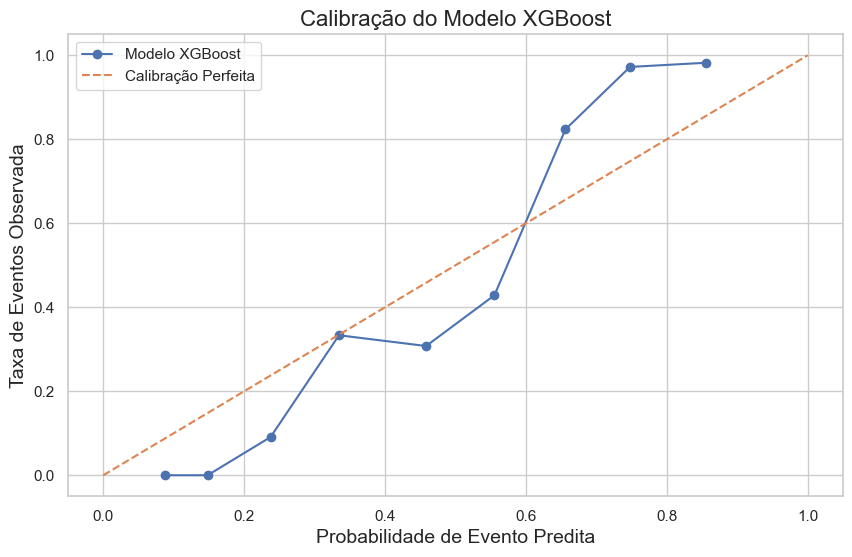

Acurácia: 0.8944, AUC: 0.9681, GINI: 0.9362, KS: 0.8156


In [13]:
def fit_logistic_regression(df, predictors, response):
    X = sm.add_constant(df[predictors])
    X['age_sex_interaction'] = X['age'] * X['sex']
    result = sm.Logit(df[response], X).fit()
    print(result.summary())
    return result

def configure_and_fit_xgboost(df, predictors, response_variable):
    xgb_model = XGBClassifier(n_estimators=200, max_depth=10, random_state=42)
    param_grid = {'learning_rate': [0.01, 0.1, 0.2], 'max_depth': [5, 10, 15]}
    grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=5, scoring='accuracy')
    grid_search.fit(df[predictors], df[response_variable])
    best_xgb_model = grid_search.best_estimator_

    feature_importances = pd.Series(best_xgb_model.feature_importances_, index=predictors)
    print("Feature Importances:")
    print(feature_importances)

    cross_val_accuracy_xgb = cross_val_score(best_xgb_model, df[predictors], df[response_variable], cv=10, scoring='accuracy').mean()
    print(f"Cross-validated XGBoost Accuracy: {cross_val_accuracy_xgb:.4f}")

    return best_xgb_model

def predict_and_calibrate(df, result_logistic, best_xgb_model, predictors):
    df['age_sex_interaction'] = df['age'] * df['sex']
    
    df['predicted_prob'] = result_logistic.predict(sm.add_constant(df[predictors + ['age_sex_interaction']]))
    df['predicted_group'] = pd.qcut(df['predicted_prob'], q=5)
    calibration_results = df.groupby('predicted_group', observed=False)[['predicted_prob', 'flag_doente']].mean()
    print(calibration_results)

    df['predicted_prob_xgb'] = best_xgb_model.predict_proba(df[predictors])[:, 1]
    df['predicted_group_xgb'] = pd.qcut(df['predicted_prob_xgb'], q=5)
    calibration_results_xgb = df.groupby('predicted_group_xgb', observed=False)[['predicted_prob_xgb', 'flag_doente']].mean()
    print(calibration_results_xgb)

    prob_true_xgb, prob_pred_xgb = calibration_curve(df['flag_doente'], df['predicted_prob_xgb'], n_bins=10)
    
    linha_calibracao_perfeita_xgb_x = np.array([0, 1])
    linha_calibracao_perfeita_xgb_y = np.array([0, 1])

    plt.figure(figsize=(10, 6))
    plt.plot(prob_pred_xgb, prob_true_xgb, marker='o', label='Modelo XGBoost')
    plt.plot(linha_calibracao_perfeita_xgb_x, linha_calibracao_perfeita_xgb_y, linestyle='--', label='Calibração Perfeita')
    plt.ylabel('Taxa de Eventos Observada', fontsize=14)
    plt.xlabel('Probabilidade de Evento Predita', fontsize=14)
    plt.title('Calibração do Modelo XGBoost', fontsize=16)
    plt.legend()
    plt.show()

# Especificando novas variáveis preditoras e ajustando a regressão logística
predictors_logistic = ['sex', 'cp', 'trestbps', 'age', 'thalach']
response_variable_logistic = 'flag_doente'
df['age_squared'] = df['age']**2
df['age_sex_squared'] = df['age']**2 * df['sex']
df['age_log'] = np.log(df['age'] + 1)
predictors_logistic += ['age_squared', 'age_sex_squared', 'age_log']
result_updated_logistic = fit_logistic_regression(df, predictors_logistic, response_variable_logistic)

# Configurando e ajustando o modelo XGBoost com busca em grade
best_xgb_model = configure_and_fit_xgboost(df, predictors_logistic, response_variable_logistic)

# Realizando previsões e calibrações
predict_and_calibrate(df, result_updated_logistic, best_xgb_model, predictors_logistic)

# Calculando e exibindo as estatísticas do modelo XGBoost
X_pred_xgb = sm.add_constant(df[predictors_logistic])[best_xgb_model.get_booster().feature_names]
y_pred_xgb = best_xgb_model.predict(X_pred_xgb)
accuracy_xgb = accuracy_score(df[response_variable_logistic], y_pred_xgb)
roc_auc_xgb = roc_auc_score(df[response_variable_logistic], best_xgb_model.predict_proba(X_pred_xgb)[:, 1])
gini_xgb = 2 * float(roc_auc_xgb) - 1
fpr_xgb, tpr_xgb, thresholds_xgb = roc_curve(df[response_variable_logistic], best_xgb_model.predict_proba(X_pred_xgb)[:, 1])
ks_xgb = max(tpr_xgb - fpr_xgb)

# Exibindo as estatísticas do modelo XGBoost
print(f"Acurácia: {accuracy_xgb:.4f}, AUC: {roc_auc_xgb:.4f}, GINI: {gini_xgb:.4f}, KS: {ks_xgb:.4f}")